## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# приводим столбец с датами к типу данных datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# группируем таблицу по группам и определяем МИН и МАКС для дат обеих выборок
date_review = data.groupby(['group']).agg({
    'date': ['min', 'max']
})
date_review


date           
             min        max
group                      
A     2021-01-02 2021-01-24
B     2021-01-02 2021-01-24

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [10]:
# группируем таблицу по группам и определяем целевые параметры
date_review_1 = data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
})
date_review_1['price'] = date_review_1['price'] / 1000000
date_review_1

,user_id,purchase,price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [13]:
a = set(data[data['group']=='A']['user_id'])
b = set(data[data['group']=='B']['user_id'])
user_intersection = a.intersection(b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [14]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.shape[0]

290688

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

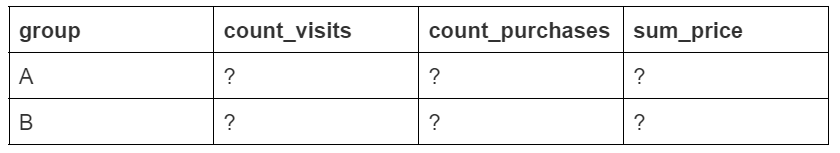
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [15]:
group_data = updated_data.groupby(['group']).agg(
    {'user_id': 'count',
     'purchase': 'sum',
     'price': 'sum'})
group_data.rename(columns={'user_id':'count_visits',
                           'purchase':'count_purchases',
                           'price':'sum_price'}, inplace=True)
print(group_data)

       count_visits  count_purchases   sum_price
group                                           
A            145307            17487  1417780000
B            145381            17290  1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Промежуточные выводы.
Количество визитов в группах А и В практически идентично, что говорит о сбалансированности выборок.
Пока по валовым показателям можно предварительно предполагать, что:
- конверсия тестовой выборки ниже, чем контрольной
- при этом, выручка и средний чек тестовой выборки выше, чем контрольной

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [20]:
group_data['conversion'] = round((group_data['count_purchases'] / group_data['count_visits'] * 100),2)
group_data['mean_check'] = round((group_data['sum_price'] / group_data['count_purchases']),0)
group_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Предварительные выводы предыдущего пункта совпадают с полученными цифрами:
- конверсия контрольной выборки выше, чем тестовой
- при этом, средний чек выше у тестовой выборки, нежели у контрольной

С точки зрения итоговой выручки пока тестовая выборка выглядит предпочтительнее.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [21]:
data_pivot = pd.pivot_table(data = updated_data, values='purchase', index='group', columns='price', aggfunc='sum')
data_pivot

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot: title={'center': 'Зависимость количества продаж от группы и цены тура'}, xlabel='price', ylabel='group'>

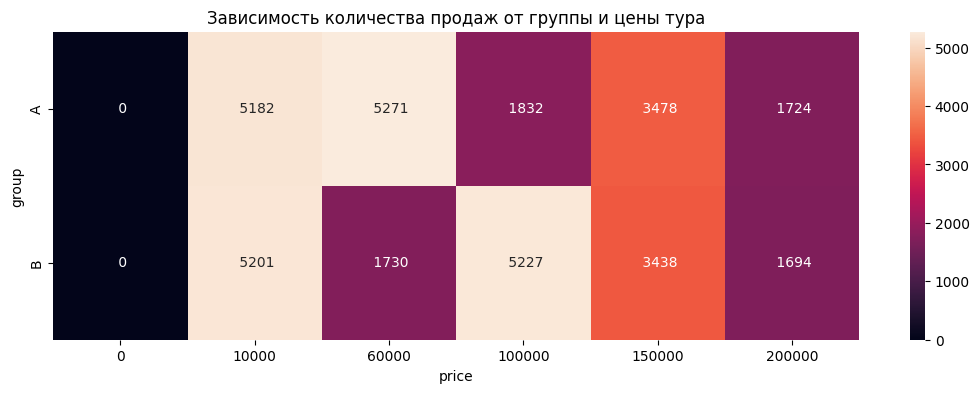

In [24]:
plt.figure(figsize = (13,4))
plt.title('Зависимость количества продаж от группы и цены тура')
sns.heatmap(data_pivot, annot=True, fmt=' d', )

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

На основании построенной тепловой карты видно, что:
- ценовые категории туров 10000, 150000, 200000 практически сопоставимы у обеих выборок
- в категориях 60000 и 100000 в контрольной выборке больше доля 60000, а в тестовой - 100000

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [30]:
cumul_data = updated_data.groupby(['date', 'group']).agg(
    {'user_id': 'count',
     'purchase': 'sum',
     'price': 'sum'
     }).reset_index()
cumul_data.rename(columns={'user_id':'count_visits',
                           'purchase':'count_purchases',
                           'price':'sum_price'}, inplace=True)
cumul_data['conversion'] = round((cumul_data['count_purchases'] / cumul_data['count_visits'] * 100),2)
cumul_data['mean_check'] = round((cumul_data['sum_price'] / cumul_data['count_purchases']),0)
cumul_data[cumul_data['date']=='2021-01-03'][['date','group','conversion', 'mean_check']]

,date,group,conversion,mean_check
2,2021-01-03,A,11.34,82888.0
3,2021-01-03,B,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [38]:
# вычисляем кумулятивную сумму количества посетителей
cumul_data['cum_users_count'] = cumul_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок
cumul_data['cum_purchases'] = cumul_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
cumul_data['cum_prices'] = cumul_data.groupby(['group'])['sum_price'].cumsum()
# вычисляем кумулятивную конверсию
cumul_data['cum_conversion'] = cumul_data['cum_purchases']/cumul_data['cum_users_count'] * 100
# вычисляем кумулятивный средний чек
cumul_data['cum_avg_check'] = cumul_data['cum_prices']/cumul_data['cum_purchases']
print('Кумулятивная конверсия в группе B на 20 января 2021 года',
      round(cumul_data[(cumul_data['date']=='2021-01-20') & (cumul_data['group']=='B')]['cum_conversion'],2))
print('Кумулятивный средний чек в группе А на 12 января 2021 года',
      round(cumul_data[(cumul_data['date']=='2021-01-12') & (cumul_data['group']=='A')]['cum_avg_check'],0))

Кумулятивная конверсия в группе B на 20 января 2021 года 37    11.9
Name: cum_conversion, dtype: float64
Кумулятивный средний чек в группе А на 12 января 2021 года 20    81492.0
Name: cum_avg_check, dtype: float64


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

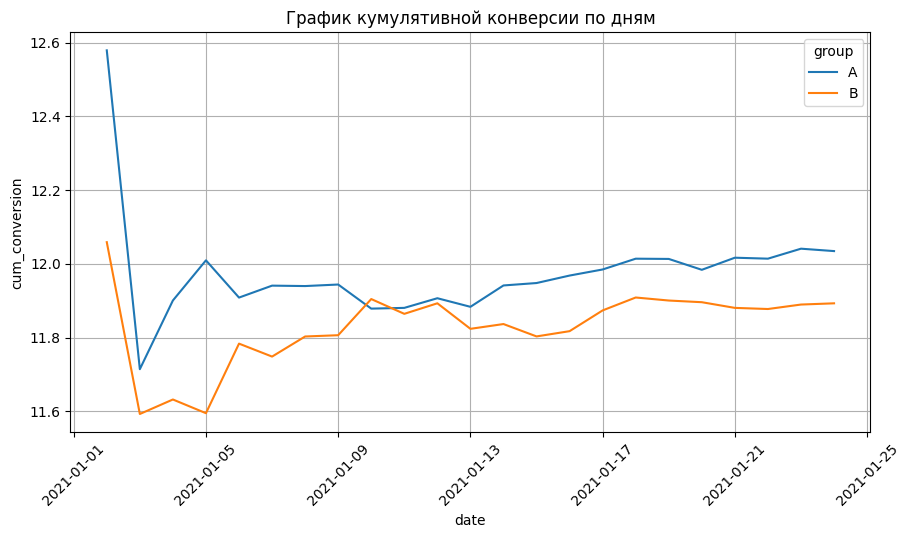

In [39]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=cumul_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

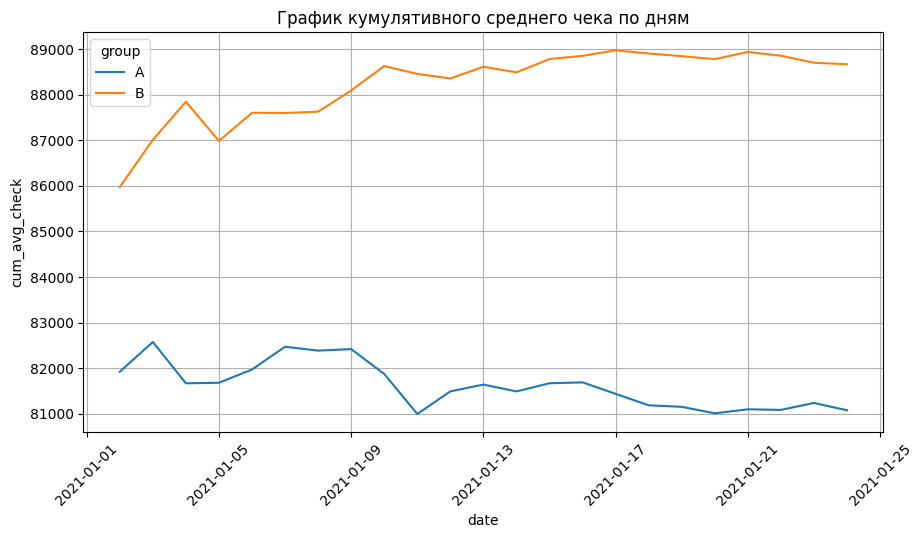

In [40]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_avg_check', data=cumul_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Графики кумулятивной конверсии и кумулятивного среднего чека показывают, что значения метрик 
во времени достаточно стабилизировались для признания А/В теста завершенным.

Резкие перепады заканчиваются до 13.01.2021, далее график достаточно стабилен.

На графике кумулятивной конверсии видно, что в контрольной выборке конверсия несколько выше, чем в тестовой.

Средний же чек, наоборот, выше в тестовой выборке по сравнению с контрольной.

Но для точного понимания необходимо произвести статистический анализ.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [41]:
# для анализа конверсии используем z-test
data_short = updated_data.groupby('group')['purchase'].agg(['sum', 'count'])

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_short['sum'], #число "успехов"
    nobs=data_short['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

p-value превышает заданный уровень значимости.

Мы не можем опровергнуть нулевую гипотезу.

Разница между конверсиями групп А и В не имеет статистической значимости.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [42]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [46]:
# зададим функцию, которая будет возвращать кортеж из вычисленных границ доверительного интервала

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [47]:
# вычислим доверительные интервалы по обеим выборкам

conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(), # размер выборки
    x_p=a_data['purchase'].mean() # выборочная пропорция
    )
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(), # размер выборки
    x_p=b_data['purchase'].mean() # выборочная пропорция
    )
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [48]:
# зададим функцию, которая будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [49]:
# вычислим доверительный интервал для разности конверсий

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы групп перекрываются.

Доверительный интервал для разности конверсий охватывает 0.

Оба вышеуказанных признака означают, что статистической разницы в конверсии между вариантами А и В нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [51]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(cumul_data[cumul_data['group']=='A']['mean_check'])
shapiro_result_b = shapiro(cumul_data[cumul_data['group']=='B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [52]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=cumul_data[cumul_data['group']=='A']['mean_check'],
    b=cumul_data[cumul_data['group']=='B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

p-value меньше, чем заданный уровень значимости. Следовательно, альтернативная гипотеза
статистически значима, разница между ежедневными средними чеками в группах А и В есть.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [56]:
# вычислим доверительный интервал для группы А

n = cumul_data[cumul_data['group']=='A'].shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = cumul_data[cumul_data['group']=='A']['mean_check'].mean() # выборочное среднее
x_std = cumul_data[cumul_data['group']=='A']['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы А: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал группы А: (79630, 82308)


In [57]:
# вычислим доверительный интервал для группы B

n = cumul_data[cumul_data['group']=='B'].shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = cumul_data[cumul_data['group']=='B']['mean_check'].mean() # выборочное среднее
x_std = cumul_data[cumul_data['group']=='B']['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечения между доверительными интервалами ежедневных средних чеков в группах А и В отсутствуют.

Это подтверждает статистическую значимость разницы между ежедневными средними чеками групп.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Проведенный анализ показал, что:

- отсутствует статистически значимая разница между конверсиями групп А и В

- присутствует статистически значимая разница между ежедневными средними чеками групп

Средний чек тестовой выборки (группа В) выше, чем средний чек контрольной выборки (группа А).
В совокупности с отсутствием разницы между конверсиями групп более предпочтительным выглядит
дизайн группы В.